In [26]:
import pandas as pd
import numpy as np
import csv
import json
import matplotlib.pyplot as plt
import plotly as ply
import seaborn as sns
import geopy.distance
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("C:/Users/Prithvi dayanand/Desktop/DML/Chicago/chicago_taxi_trips_2016_01.csv")

In [3]:
data.isna().sum()

taxi_id                        23
trip_start_timestamp            0
trip_end_timestamp            125
trip_seconds                  314
trip_miles                     14
pickup_census_tract       1705805
dropoff_census_tract       738326
pickup_community_area      285789
dropoff_community_area     313655
fare                           33
tips                           33
tolls                          33
extras                         33
trip_total                     33
payment_type                    0
company                    632726
pickup_latitude            285757
pickup_longitude           285757
dropoff_latitude           311682
dropoff_longitude          311682
dtype: int64

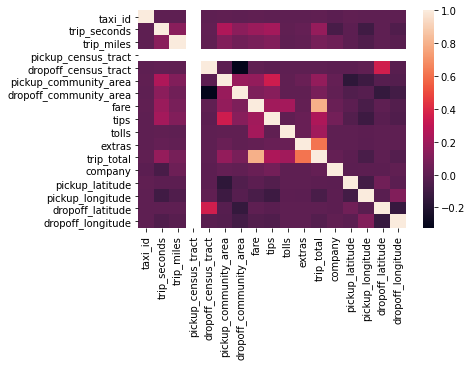

In [4]:
correlation= data.corr()
sn.heatmap(correlation, annot=False)
plt.show()

### Preprocessing 

In [5]:
print('''Dropping the columns which aren't required for prediction''')
data.drop("pickup_census_tract", axis=1, inplace=True)
data.drop("dropoff_census_tract", axis=1, inplace=True)
data=data.drop(["tips"], axis="columns")
data=data.drop(["tolls"], axis="columns")
data=data.drop(["extras"], axis="columns")
data=data.drop(["trip_total"], axis="columns")
data=data.drop(["payment_type"], axis="columns")
data=data.drop(["taxi_id"], axis='columns')
data=data.drop(["company"], axis='columns')
data=data.drop(index=data[data["fare"].isna()].index)

Dropping the columns which aren't required for prediction


In [6]:
print('''Correlation matrix''')
rs = np.random.RandomState(0)
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')


Correlation matrix


,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
trip_seconds,1.000000,0.134308,0.246059,0.139301,0.188177,-0.005592,-0.097252,-0.001501,-0.048807
trip_miles,0.134308,1.000000,0.109671,0.057842,0.082282,-0.003070,-0.047441,-0.001033,-0.022089
pickup_community_area,0.246059,0.109671,1.000000,0.178544,0.163656,-0.160377,-0.109311,-0.024813,-0.029055
dropoff_community_area,0.139301,0.057842,0.178544,1.000000,0.096247,-0.041703,-0.027013,-0.140689,-0.089147
fare,0.188177,0.082282,0.163656,0.096247,1.000000,-0.003543,-0.068600,-0.001510,-0.038514
pickup_latitude,-0.005592,-0.003070,-0.160377,-0.041703,-0.003543,1.000000,-0.085840,0.058767,-0.008549
pickup_longitude,-0.097252,-0.047441,-0.109311,-0.027013,-0.068600,-0.085840,1.000000,-0.017301,0.107737
dropoff_latitude,-0.001501,-0.001033,-0.024813,-0.140689,-0.001510,0.058767,-0.017301,1.000000,-0.131826
dropoff_longitude,-0.048807,-0.022089,-0.029055,-0.089147,-0.038514,-0.008549,0.107737,-0.131826,1.000000


In [7]:
print('Removing the records with missing latitude or longitude')
data=data.drop(index=data[(data["pickup_latitude"].isna()) | (data["pickup_longitude"].isna()) | (data["dropoff_latitude"].isna()) | (data["dropoff_longitude"].isna())].index)

Removing the records with missing latitude or longitude


In [8]:
mean_trip_seconds = data["trip_seconds"].mean()
data["trip_seconds"] = data["trip_seconds"].replace(['NaN'], round(mean_trip_seconds))

In [9]:
data=data.drop(index=data[data["pickup_community_area"].isnull()].index)
data=data.drop(index=data[data["dropoff_community_area"].isnull()].index)

In [10]:
data.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.4,24.0,24.0,4.5,199.0,510.0,199.0,510.0
3,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.1,6.0,6.0,7.0,686.0,500.0,686.0,500.0


### Transformation


In [11]:
print('Splitting the timestamp and extarcting the day and time')
data["trip_start_time"] = data['trip_start_timestamp'].str.split(" ", n=1, expand=True)[1]
data["trip_end_time"] = data['trip_end_timestamp'].str.split(" ", n=1, expand=True)[1]
data["trip_day"]= pd.to_datetime(data['trip_start_timestamp']).dt.day_name()

Splitting the timestamp and extarcting the day and time


In [12]:
data["trip_start_time"]=data["trip_start_time"].str.replace(":", "")
data["trip_start_time_hour"]=data["trip_start_time"].astype(int)

In [13]:
data["trip_end_time"]=data["trip_end_time"].str.replace(":", "")
data["trip_end_time_hour"]=data["trip_end_time"].astype(int)

In [14]:
data["isPeak"] = data["trip_start_time_hour"].apply(lambda x :1 if ((len(str(x)) == 5) & ((x > 70000) & (x < 100000)) | (len(str(x)) == 6) & ( ((x < 110000) & (x < 100000))  | ((x > 160000) & (x < 193000)) )) else 0)

In [15]:
data["isDayTime"]=data["trip_start_time_hour"].apply(lambda x :1 if ((len(str(x)) == 5) & (x > 60000)  | (len(str(x)) == 6) & ( (x > 100000) & (x < 183000))) else 0)

In [16]:
data.drop("trip_start_timestamp", axis=1, inplace=True)
data.drop("trip_end_timestamp", axis=1, inplace=True)

In [17]:
# Load lookup table given in kaggle
lt = pd.read_json("C:/Users/Prithvi dayanand/Desktop/DML/Chicago/column_remapping.json")
# Change indices with the real value
data['pickup_latitude'] = data['pickup_latitude'].map(lambda x: lt.pickup_latitude[x])
data['pickup_longitude'] = data['pickup_longitude'].map(lambda x: lt.pickup_longitude[x])
data['dropoff_latitude'] = data['dropoff_latitude'].map(lambda x: lt.dropoff_latitude[x])
data['dropoff_longitude'] = data['dropoff_longitude'].map(lambda x: lt.dropoff_longitude[x])

In [18]:
data.head(2)

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_start_time,trip_end_time,trip_day,trip_start_time_hour,trip_end_time_hour,isPeak,isDayTime
0,180.0,0.4,24.0,24.0,4.5,41.901207,-87.676356,41.901207,-87.676356,061500,061500,Wednesday,61500,61500,0,1
3,480.0,1.1,6.0,6.0,7.0,41.944227,-87.655998,41.944227,-87.655998,173000,173000,Saturday,173000,173000,1,1


In [19]:
# Calculate lineal distance or displacement using coordinates
def calculate_distance(src):
    coords_1 = (src["pickup_latitude"], src["pickup_longitude"])
    coords_2 = (src["dropoff_latitude"],src["dropoff_longitude"])
    return geopy.distance.distance(coords_1, coords_2).m

# Generate lineal distance field
data['distance'] = data.apply(calculate_distance, axis='columns')

In [ ]:
# import reverse_geocoder
# r=[]
# for i in range(0,10000):
#     r.append(reverse_geocoder.search([data["pickup_latitude"].iloc[i], data["pickup_longitude"].iloc[i]]))

# c=(41.892508,-87.626215)

# def pickup_location(src):
#     coords_1= (src["pickup_latitude"])
#     coords_2= (src["pickup_longitude"])
#     return reverse_geocoder.search([coords_1, coords_2])
    
# data['pickup'] = data.apply(pickup_location, axis='columns')
data.head(4)

In [20]:
data['pickup'] = data['pickup_latitude'].apply(lambda x: 1 if x < 41.8781 else 0) & data['pickup_longitude'].apply(lambda x: 1 if x < 88.0118 else 0)
data['drop'] = data['dropoff_latitude'].apply(lambda x: 1 if x < 41.8781 else 0) & data['dropoff_longitude'].apply(lambda x: 1 if x < 88.0118 else 0)

In [30]:
data=data.drop(["trip_start_time"], axis="columns")
data=data.drop(["trip_end_time"], axis="columns")

### Categorizing the obtained cities into 2 i.e; suburbs and downtown and one hot encoding them

In [21]:
print('''Placing 1 if the ride begun at suburbs and 0 if the ride begun at downtown''')
citydummies = pd.get_dummies(data['pickup'])
data = pd.concat([data, citydummies], axis='columns')
data.head(2)

Placing 1 if the ride begun at suburbs and 0 if the ride begun at downtown


,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_start_time,...,trip_day,trip_start_time_hour,trip_end_time_hour,isPeak,isDayTime,distance,pickup,drop,0,1
0,180.0,0.4,24.0,24.0,4.5,41.901207,-87.676356,41.901207,-87.676356,061500,...,Wednesday,61500,61500,0,1,0.0,0,0,1,0
3,480.0,1.1,6.0,6.0,7.0,41.944227,-87.655998,41.944227,-87.655998,173000,...,Saturday,173000,173000,1,1,0.0,0,0,1,0


In [22]:
print('''Renaming the columns as Downtown and Suburb''')
data=data.rename(columns= {0:'Downtown', 1:'Suburb'})
data=data.drop(["pickup","drop","pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude" ], axis='columns')

Renaming the columns as Downtown and Suburb


In [23]:
data.head(2)

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,trip_start_time,trip_end_time,trip_day,trip_start_time_hour,trip_end_time_hour,isPeak,isDayTime,distance,Downtown,Suburb
0,180.0,0.4,24.0,24.0,4.5,061500,061500,Wednesday,61500,61500,0,1,0.0,1,0
3,480.0,1.1,6.0,6.0,7.0,173000,173000,Saturday,173000,173000,1,1,0.0,1,0


### Removing the outliers which are above 300 dollors and above

Before removing outliers


<AxesSubplot:xlabel='fare'>

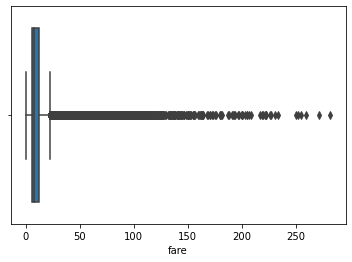

In [27]:
print('''Before removing outliers''')
sns.boxplot(x=data['fare'])

In [28]:
data["farecheck"]=data["fare"].apply(lambda x : 1 if x > 300 else 0)
filter= data["fare"] < 300
data.where(filter,inplace=True)

After removing outliers


<AxesSubplot:xlabel='fare'>

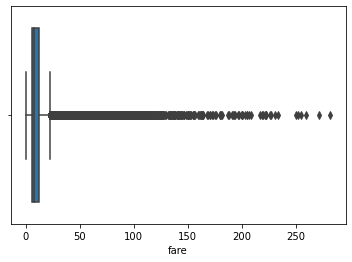

In [29]:
print('''After removing outliers''')
sns.boxplot(x=data['fare'])

C:\Users\Prithvi dayanand\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='distance', ylabel='Density'>

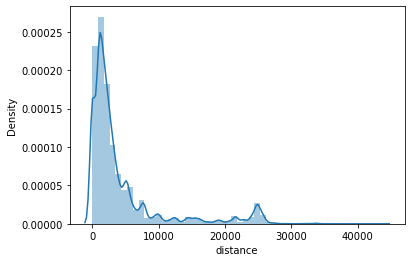

In [34]:
sns.distplot(data["distance"])

C:\Users\Prithvi dayanand\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='distance', ylabel='Density'>

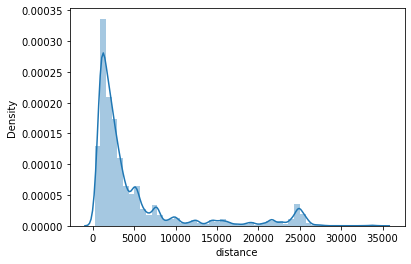

In [35]:
data = data[data.distance != 0]
data = data[data.distance <= 35000]
sns.distplot(data["distance"])

In [39]:
sns.countplot(data["trip_day"])


Index(['trip_seconds', 'trip_miles', 'pickup_community_area',
       'dropoff_community_area', 'fare', 'trip_start_time_hour',
       'trip_end_time_hour', 'isPeak', 'isDayTime', 'distance', 'Downtown',
       'Suburb', 'farecheck', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

### One hot encoding

In [44]:
weekday_dummies=pd.get_dummies(data["trip_day"])
data=pd.concat([data, weekday_dummies], axis='columns')
data=data.drop(["trip_day"], axis="columns")

In [71]:
data.head(2)

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,trip_start_time_hour,trip_end_time_hour,isPeak,isDayTime,distance,Downtown,Suburb,farecheck,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
5,1080.0,6.2,8.0,3.0,17.75,181500.0,184500.0,1.0,1.0,7588.575486,1.0,0.0,0.0,1,0,0,0,0,0,0
8,180.0,0.0,8.0,32.0,5.00,113000.0,114500.0,0.0,1.0,941.060331,1.0,0.0,0.0,1,0,0,0,0,0,0


In [70]:
print('''Correlation matrix''')
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

Correlation matrix


C:\Users\Prithvi dayanand\anaconda3\lib\site-packages\pandas\io\formats\style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
C:\Users\Prithvi dayanand\anaconda3\lib\site-packages\pandas\io\formats\style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,trip_start_time_hour,trip_end_time_hour,isPeak,isDayTime,distance,Downtown,Suburb,farecheck,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
trip_seconds,1.000000,0.137822,0.312493,0.187556,0.677182,0.029241,0.034191,0.080681,0.041508,0.593486,-0.084647,0.084647,nan,0.004653,0.018997,-0.043132,-0.023030,0.025091,0.008630,0.010510
trip_miles,0.137822,1.000000,0.115952,0.066592,0.212902,0.003308,0.005940,-0.004358,0.004668,0.208428,-0.019044,0.019044,nan,-0.002699,0.007523,-0.009029,0.003559,0.003517,-0.000889,-0.000523
pickup_community_area,0.312493,0.115952,1.000000,0.005395,0.506517,0.120252,0.125999,0.038425,0.074679,0.546483,-0.247511,0.247511,nan,-0.020687,0.053138,-0.100212,-0.053564,0.042388,0.047736,0.041752
dropoff_community_area,0.187556,0.066592,0.005395,1.000000,0.321334,-0.060066,-0.049094,0.049935,0.167783,0.334997,-0.085166,0.085166,nan,-0.006246,0.034042,-0.078889,-0.044512,0.036038,0.032144,0.033319
fare,0.677182,0.212902,0.506517,0.321334,1.000000,0.017035,0.028392,-0.013125,0.016778,0.945866,-0.119826,0.119826,nan,-0.025870,0.038948,-0.046197,0.021698,0.016975,0.003923,0.000262
trip_start_time_hour,0.029241,0.003308,0.120252,-0.060066,0.017035,1.000000,0.957429,0.093083,-0.116661,0.012687,-0.025917,0.025917,nan,0.018114,0.011574,-0.015345,-0.202527,0.069041,0.049215,0.061543
trip_end_time_hour,0.034191,0.005940,0.125999,-0.049094,0.028392,0.957429,1.000000,0.110882,-0.088833,0.023151,-0.026182,0.026182,nan,0.014809,0.014995,-0.023331,-0.200710,0.070867,0.052117,0.064128
isPeak,0.080681,-0.004358,0.038425,0.049935,-0.013125,0.093083,0.110882,1.000000,0.313465,-0.030147,-0.007613,0.007613,nan,-0.007327,0.046814,-0.077450,-0.109218,0.042997,0.057178,0.052148
isDayTime,0.041508,0.004668,0.074679,0.167783,0.016778,-0.116661,-0.088833,0.313465,1.000000,0.015062,-0.042919,0.042919,nan,-0.015961,0.068010,-0.127900,-0.118260,0.056048,0.078848,0.069698
distance,0.593486,0.208428,0.546483,0.334997,0.945866,0.012687,0.023151,-0.030147,0.015062,1.000000,-0.102362,0.102362,nan,-0.024022,0.042275,-0.045662,0.025682,0.013040,0.001039,-0.002546


In [47]:
data = data.drop(index=data[data.isna().any(axis=1)].index)

In [48]:
data

,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,trip_start_time_hour,trip_end_time_hour,isPeak,isDayTime,distance,Downtown,Suburb,farecheck,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
5,1080.0,6.2,8.0,3.0,17.75,181500.0,184500.0,1.0,1.0,7588.575486,1.0,0.0,0.0,1,0,0,0,0,0,0
8,180.0,0.0,8.0,32.0,5.00,113000.0,114500.0,0.0,1.0,941.060331,1.0,0.0,0.0,1,0,0,0,0,0,0
10,480.0,1.3,8.0,8.0,7.00,90000.0,90000.0,1.0,1.0,1527.140786,1.0,0.0,0.0,0,1,0,0,0,0,0
11,420.0,0.0,8.0,28.0,7.25,231500.0,233000.0,0.0,0.0,1601.150845,1.0,0.0,0.0,0,0,0,0,0,0,1
12,1380.0,5.1,32.0,31.0,17.25,183000.0,190000.0,1.0,0.0,4740.212665,1.0,0.0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705799,540.0,0.2,32.0,7.0,12.25,90000.0,90000.0,1.0,1.0,3886.179349,1.0,0.0,0.0,0,0,0,0,0,1,0
1705800,840.0,2.4,22.0,7.0,10.25,193000.0,194500.0,0.0,0.0,4119.899881,1.0,0.0,0.0,0,0,1,0,0,0,0
1705802,1380.0,17.9,32.0,76.0,44.00,63000.0,64500.0,0.0,1.0,25903.648791,0.0,1.0,0.0,0,0,0,0,1,0,0
1705803,960.0,2.5,8.0,28.0,11.75,123000.0,124500.0,0.0,1.0,2790.888479,1.0,0.0,0.0,0,0,0,1,0,0,0


# Feature selection 


In [49]:
X=data.loc[:, ['trip_seconds','trip_miles','isPeak','isDayTime','Suburb', 'Downtown', 'Friday','Monday','Saturday','Sunday','Thursday','Tuesday','Wednesday']]
y=data["fare"]

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
len(X_train)
len(X_test)

240944

# Multiple Regression

In [52]:
from sklearn.linear_model import LinearRegression
regressor=LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [53]:
y_predmulti=regressor.predict(X_test)
y_predmulti

array([10.36164425, 21.2700803 ,  8.74351331, ..., 17.98397314,
        8.15150604, 12.70353241])

In [54]:
y_test

924181      9.25
992996     34.00
632075      6.75
1289274     8.75
1128503     5.25
           ...  
1051162    44.75
455439      4.50
1080760    29.25
1459541     5.75
1270740    11.00
Name: fare, Length: 240944, dtype: float64

In [55]:
from sklearn.model_selection import cross_val_score
cross_val_score(regressor, X, y).mean()

0.4830753423467146

In [56]:
from sklearn.metrics import r2_score
score=r2_score(y_test,y_predmulti)
score

0.5450731864210887

# Decision Tree

In [57]:
from sklearn import tree
reg=tree.DecisionTreeRegressor(random_state=0)
reg.fit(X_train,y_train)

DecisionTreeRegressor(random_state=0)

In [58]:
y_pred = reg.predict(X_test)
y_pred

array([ 8.28715596, 34.33333333,  6.54910448, ..., 28.875     ,
        5.76049689, 10.85188679])

In [59]:
y_test

924181      9.25
992996     34.00
632075      6.75
1289274     8.75
1128503     5.25
           ...  
1051162    44.75
455439      4.50
1080760    29.25
1459541     5.75
1270740    11.00
Name: fare, Length: 240944, dtype: float64

In [60]:
from sklearn.metrics import r2_score
score=r2_score(y_test,y_pred)
score

0.9481561272982169

In [84]:
adj = 1-(1-reg.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)

In [85]:
adj

0.9794624798467894

# Xgboost

In [86]:
import xgboost
regx=xgboost.XGBRegressor()
regx.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [87]:
y_pred1=regx.predict(X_test)

In [88]:
adjr = 1-(1-regx.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)

In [89]:
adjr

0.9672943189152327

In [81]:
from sklearn.metrics import r2_score
score=r2_score(y_test,y_pred1)
score


# Random Forest

In [64]:
from sklearn.ensemble import RandomForestRegressor
regressor=RandomForestRegressor(random_state=0)
regressor.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

In [65]:
y_random=regressor.predict(X_test)

In [66]:
print(y_test)

924181      9.25
992996     34.00
632075      6.75
1289274     8.75
1128503     5.25
           ...  
1051162    44.75
455439      4.50
1080760    29.25
1459541     5.75
1270740    11.00
Name: fare, Length: 240944, dtype: float64


In [68]:
mean_check = data['fare'].mean()
mean_check

12.722746349978832

In [72]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_random, y_test))
print(rmse)

2.258700375258823


In [90]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_random))

MAE: 0.7417038200463885


In [91]:
adjr = 1-(1-regressor.score(X_train, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)

In [92]:
adjr

0.9772393644537791